<div class="alert alert-danger" role="alert">
    <span style="font-size:20px">&#9888;</span> <span style="font-size:16px">This is a read-only notebook! If you want to make and save changes, save a copy by clicking on <b>File</b> &#8594; <b>Save a copy</b>. If this is already a copy, you can delete this cell.</span>
</div>

<h1>Interaction search using LASSO regression with forced in variables<span class="tocSkip"></span></h1>

This notebook showcases a trick for 'incremental variable' search using LASSO (can be done with regression and logistic regression), where the scale of the 'forced in variables' is massively increased, so their coefficients become tiny and therefore not regulatized.

This notebook provides a very simple example.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<ul class="toc-item"><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Set-up-the-data" data-toc-modified-id="Set-up-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set up the data</a></span></li><li><span><a href="#Perform-LASSO-regression" data-toc-modified-id="Perform-LASSO-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Perform LASSO regression</a></span></li><li><span><a href="#Recalibrating-the-selected-model" data-toc-modified-id="Recalibrating-the-selected-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recalibrating the selected model</a></span></li><li><span><a href="#Compare-model-fit-with-base-model" data-toc-modified-id="Compare-model-fit-with-base-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Compare model fit with base model</a></span></li></ul>

# Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import sklearn.model_selection as modsel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

# Automatically update custom py scripts that are loaded in
%load_ext autoreload
%autoreload 2

# Add path of the folder 'resources' to the path from which we can import modules  
import sys
sys.path.insert(0, "../../utilities")
from classification import sklearn_classification_tools

C:\Users\daniel.wang\AppData\Local\Temp\ipykernel_137404\2370028670.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Set up the data

In [3]:
train_data = pd.read_csv("sample_input/train.csv")
test_data = pd.read_csv("sample_input/test.csv")
DV_train = train_data['Survived']

In [4]:
# Perform logistic regression on the base model
base_variables = ["age_imputed", "class_12", "log_fare", "sibling_above_2"]
base_model = LogisticRegression(fit_intercept=True, penalty=None)
base_model = base_model.fit(X=train_data[base_variables], y=DV_train)

In [5]:
# Define interaction variables
# This was done ahead of time. Ideally you would identify potential interactions through hypotheses and/or model diagnostic plots

interaction_variables = list(train_data.columns.values[23:])
interaction_variables

['age_imputed_x_Parch',
 'age_imputed_x_class_12',
 'age_imputed_x_embarked_S',
 'age_imputed_x_log_fare',
 'Parch_x_age_imputed',
 'Parch_x_class_12',
 'Parch_x_embarked_S',
 'Parch_x_log_fare',
 'class_12_x_age_imputed',
 'class_12_x_Parch',
 'class_12_x_log_fare',
 'embarked_S_x_age_imputed',
 'embarked_S_x_Parch',
 'embarked_S_x_log_fare',
 'log_fare_x_age_imputed',
 'log_fare_x_Parch',
 'log_fare_x_class_12',
 'log_fare_x_embarked_S']

In [6]:
# Combine base variables and interaction variables into a single list
all_IV = base_variables + interaction_variables

# Select only the columns in the list 'all_IV' from the training data
X_train = train_data[all_IV]

# Initialize a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the training data and transform it, then convert the result to a DataFrame
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=all_IV)

# Multiply the base variables in the scaled training data by 100
X_train_scaled[base_variables] = 100*X_train_scaled[base_variables]

# Select only the columns in the list 'all_IV' from the testing data
X_test = test_data[all_IV]

# Transform the testing data using the scaler fitted to the training data, then convert the result to a DataFrame
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=all_IV)

# Multiply the base variables in the scaled testing data by 100
X_test_scaled[base_variables] = 100*X_test_scaled[base_variables]


# Perform LASSO regression

In [7]:
# OLD CODE, use next cell instead since we have some utility functions for it

# param_grid_ = {'C': [1e-5, 1e-4, 1e-3, 1e-2, 0.05,0.1,0.15,0.2,0.5, 1e0, 1e1, 1e2]}
# lasso_search = modsel.GridSearchCV(
#     LogisticRegression(random_state=100000, penalty = "l1", fit_intercept=True, intercept_scaling=1000, solver="liblinear", max_iter=10000), 
#     cv=5, param_grid=param_grid_, return_train_score=True, verbose=1)

# lasso_search = lasso_search.fit(X_train_scaled, DV_train)
# lasso_search.cv_results_['mean_test_score']

In [8]:
from sklearn.model_selection import StratifiedKFold
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds)

from sklearn.linear_model import LogisticRegressionCV

Lasso_CV_model = LogisticRegressionCV(Cs=[1e-5, 1e-4, 1e-3, 1e-2, 0.05,0.1,0.15,0.2,0.5, 1e0, 1e1, 1e2], 
                                      cv=cv, penalty='l1', solver='liblinear', random_state=1000, 
                                      fit_intercept=True, intercept_scaling=1000,
                                      refit=True)

Lasso_CV_outcomes = Lasso_CV_model.fit(X_train_scaled, DV_train)

**Speed of coefficients moving to zero (for a general sense)**

TODO: Remove the forced in variables from this chart

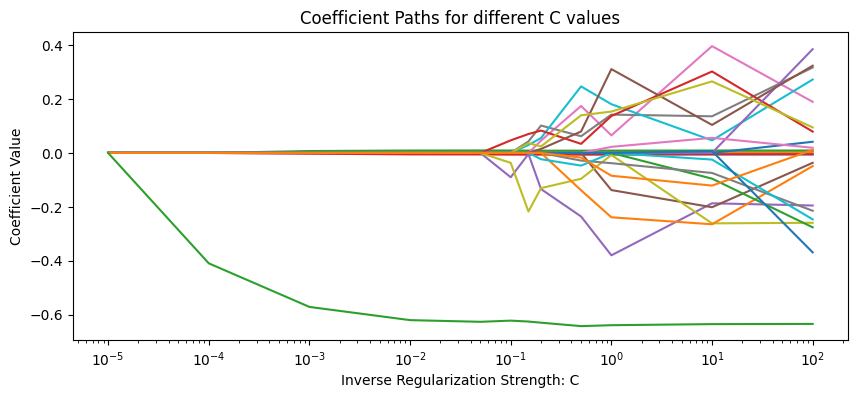

In [9]:
coefs_paths = Lasso_CV_outcomes.coefs_paths_[1][0]
plt.figure(figsize=(10, 4))
for i in range(coefs_paths.shape[1]):
    plt.plot(Lasso_CV_outcomes.Cs_, coefs_paths[:, i], label=f'Coefficient {i+1}')

plt.xscale('log')
plt.xlabel('Inverse Regularization Strength: C')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Paths for different C values')
plt.show()


In [10]:
Lasso_CV_metrics = sklearn_classification_tools.get_LogisticRegressionCV_path(Lasso_CV_outcomes, X_train_scaled, DV_train, cv = cv, threshold = np.mean(DV_train))
Lasso_CV_metrics

Working on #1 out of #12 values of C
Working on #2 out of #12 values of C
Working on #3 out of #12 values of C
Working on #4 out of #12 values of C
Working on #5 out of #12 values of C
Working on #6 out of #12 values of C
Working on #7 out of #12 values of C
Working on #8 out of #12 values of C
Working on #9 out of #12 values of C
Working on #10 out of #12 values of C
Working on #11 out of #12 values of C
Working on #12 out of #12 values of C


,C,Accuracy,F1 Score,Average precision,AUC,# Variables
0,0.00001,0.375000,0.204545,0.375000,0.500000,0
1,0.00010,0.375000,0.204545,0.375000,0.500000,0
2,0.00100,0.536538,0.522162,0.589518,0.713120,4
3,0.01000,0.592308,0.590196,0.602663,0.724623,4
4,0.05000,0.663462,0.668804,0.603831,0.723913,6
5,0.10000,0.661538,0.666505,0.618296,0.728063,12
6,0.15000,0.667308,0.671812,0.626190,0.729688,16
7,0.20000,0.667308,0.671226,0.629068,0.730809,16
8,0.50000,0.673077,0.675861,0.637273,0.727479,18
9,1.00000,0.682692,0.684572,0.639967,0.723582,18


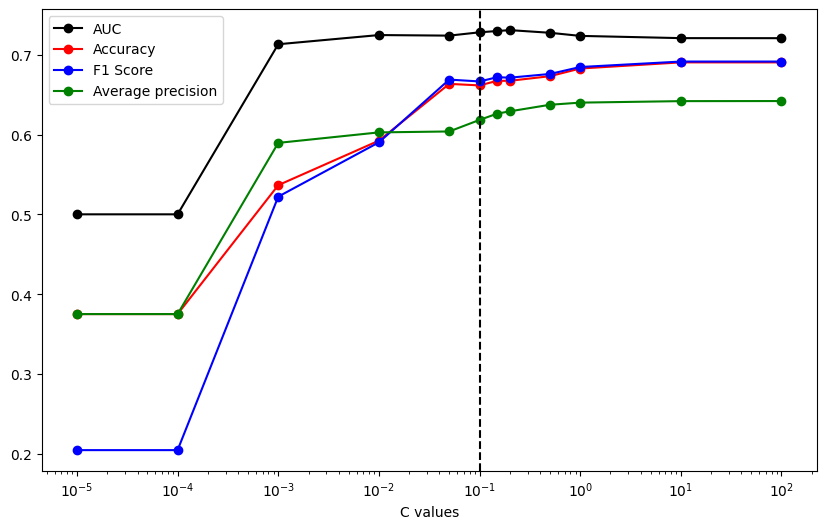

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.semilogx(Lasso_CV_outcomes.Cs_, Lasso_CV_metrics['AUC'], 'k', label='AUC', marker='o')
ax.semilogx(Lasso_CV_outcomes.Cs_, Lasso_CV_metrics['Accuracy'], 'red', label='Accuracy', marker='o')
ax.semilogx(Lasso_CV_outcomes.Cs_, Lasso_CV_metrics['F1 Score'], 'blue', label='F1 Score', marker='o')
ax.semilogx(Lasso_CV_outcomes.Cs_, Lasso_CV_metrics['Average precision'], 'green', label='Average precision', marker='o')
ax.legend()
ax.set_xlabel('C values')
ax.axis('tight')
ax.axvline(Lasso_CV_outcomes.C_, linestyle='--', color='k', label='Chosen C')

# Recalibrating the selected model 

In [12]:
C = 0.1
lasso = LogisticRegression(C = C, random_state=100000, penalty = "l1", fit_intercept=True, intercept_scaling=1000,solver='liblinear')
lasso = lasso.fit(X_train_scaled, DV_train)

In [13]:
variables = all_IV
coef = [(lasso.coef_[0][i]) for i in range(len(lasso.coef_[0])) if lasso.coef_[0][i] != 0]
relevant_var = [variables[i] for i in range(len(lasso.coef_[0])) if lasso.coef_[0][i] != 0]
lasso_imp = dict(zip(relevant_var, coef))
pd.DataFrame({0:lasso_imp})

,0
age_imputed,-0.003322
class_12,0.002734
log_fare,0.006731
sibling_above_2,-0.005616
age_imputed_x_Parch,-0.170229
age_imputed_x_log_fare,0.071088
Parch_x_age_imputed,-0.012211
Parch_x_class_12,0.000267
Parch_x_embarked_S,0.037626
class_12_x_Parch,0.049662


# Compare model fit with base model

In [14]:
base_OOS = base_model.predict_proba(X=test_data[base_variables])[:,1]

In [15]:
interaction_OOS = lasso.predict_proba(X=X_test_scaled)[:,1]

In [16]:
roc_auc_score(test_data['Survived'], base_OOS)*2-1 #Gini of base model

0.5662657920310983

In [17]:
roc_auc_score(test_data['Survived'], interaction_OOS)*2-1 #Gini of interaction model

0.5822096695821188

**See the Model performance and diagnostics plots notebook for more ways to evaluate and compare**